### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Load Data and Initial Processing

In [ ]:
df = pd.read_csv("uidai\data\enrollment.csv")

# parse date
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

print(df.head())
print(df.info())


        date                        state                  district  pincode  \
0 2025-10-26  andaman and nicobar islands                  Andamans   744105   
1 2025-10-26  andaman and nicobar islands             South Andaman   744103   
2 2025-10-27  andaman and nicobar islands                  Andamans   744103   
3 2025-10-27  andaman and nicobar islands                   Nicobar   744301   
4 2025-10-28  andaman and nicobar islands  North And Middle Andaman   744201   

   age_0_5  age_5_17  age_18_greater  
0        1         0               0  
1        1         0               0  
2        2         0               0  
3        1         0               0  
4        1         0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006007 entries, 0 to 1006006
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   date            1006007 non-null  datetime64[ns]
 1   state 

### Calculate Total Enrollment

In [ ]:
df['total_enrollment'] = (
    df['age_0_5'] +
    df['age_5_17'] +
    df['age_18_greater']
)


### Aggregate Daily District Data

In [ ]:
daily_district = (
    df.groupby(['date', 'state', 'district'], as_index=False)
      .agg({
          'age_0_5': 'sum',
          'age_5_17': 'sum',
          'age_18_greater': 'sum',
          'total_enrollment': 'sum'
      })
)

daily_district.sort_values(['district', 'date'], inplace=True)
print(daily_district.head())


            date        state            district  age_0_5  age_5_17  \
782   2025-06-01  west bengal  24 Paraganas North      540       399   
1109  2025-07-01  west bengal  24 Paraganas North     2637      2059   
1110  2025-07-01  west bengal  24 Paraganas South      364       104   
55556 2025-11-25       odisha               ANGUL        1         0   
4293  2025-09-04       odisha              ANUGUL        0         1   

       age_18_greater  total_enrollment  
782               111              1050  
1109              401              5097  
1110               22               490  
55556               0                 1  
4293                0                 1  


### Calculate Rolling Mean and Standard Deviation

In [ ]:
WINDOW = 7  # days

daily_district['rolling_mean'] = (
    daily_district
    .groupby('district')['total_enrollment']
    .transform(lambda x: x.rolling(WINDOW, min_periods=3).mean())
)

daily_district['rolling_std'] = (
    daily_district
    .groupby('district')['total_enrollment']
    .transform(lambda x: x.rolling(WINDOW, min_periods=3).std())
)


### Calculate Z-score and Identify Anomalies

In [ ]:
daily_district['z_score'] = (
    (daily_district['total_enrollment'] - daily_district['rolling_mean']) /
    daily_district['rolling_std']
)

# avoid division noise
daily_district.replace([np.inf, -np.inf], np.nan, inplace=True)

THRESHOLD = 1.5 # Lowered threshold to detect more anomalies
daily_district['anomaly'] = daily_district['z_score'].abs() > THRESHOLD

print(daily_district[daily_district['anomaly']])

            date           state  district  age_0_5  age_5_17  age_18_greater  \
58143 2025-12-22          odisha    ANUGUL        2         0               0   
4628  2025-09-05  andhra pradesh  Adilabad        9         1               0   
7592  2025-09-08       telangana  Adilabad       66        16               0   
14325 2025-09-16       telangana  Adilabad       62        18               0   
20802 2025-09-24       telangana  Adilabad       34        12               0   
...          ...             ...       ...      ...       ...             ...   
28038 2025-10-17       karnataka    yadgir       14         4               0   
37667 2025-10-30       karnataka    yadgir       34         1               0   
51027 2025-11-15       karnataka    yadgir       15         1               0   
54513 2025-11-19       karnataka    yadgir       33         1               0   
64806 2025-12-31       karnataka    yadgir       11         8               0   

       total_enrollment  ro

### Identify Hotspots

In [ ]:
hotspots = (
    daily_district[daily_district['anomaly']]
    .groupby(['state', 'district'])
    .agg(
        anomaly_days=('date', 'count'),
        max_spike=('z_score', 'max'),
        max_drop=('z_score', 'min')
    )
    .reset_index()
    .sort_values('anomaly_days', ascending=False)
)

print(hotspots)


                 state        district  anomaly_days  max_spike  max_drop
153       chhattisgarh          Bastar            16   2.244920 -1.586224
384          karnataka  Uttara Kannada            14   2.205960 -2.110026
17      andhra pradesh          Guntur            14   2.044882 -2.033283
290  jammu and kashmir          Kargil            14   2.214144 -2.110026
155       chhattisgarh         Bijapur            14   2.205699 -1.701222
..                 ...             ...           ...        ...       ...
826      uttar pradesh    Kushinagar *             1   1.788854  1.788854
57   arunachal pradesh        Shi-yomi             1   2.244540  2.244540
405             ladakh             Leh             1   1.700840  1.700840
43   arunachal pradesh           Anjaw             1   2.054210  2.054210
47   arunachal pradesh           Kamle             1   2.267787  2.267787

[912 rows x 5 columns]


### Visualize Enrollment Anomalies for the Top Hotspot District

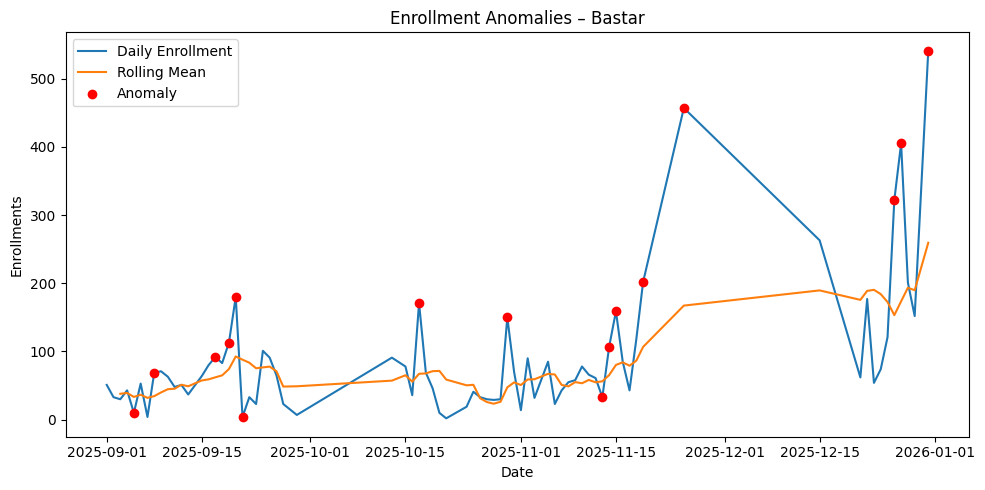

In [ ]:
# Check if there are any hotspots detected after the anomaly calculation
if not hotspots.empty:
    # Pick the district with the most anomaly days
    district_name = hotspots['district'].iloc[0]
else:
    # If no hotspots, try to find the district with the maximum absolute z-score
    # Filter out NaN z_scores first to find a meaningful maximum
    valid_z_scores = daily_district.dropna(subset=['z_score'])
    if not valid_z_scores.empty:
        # Get the index of the maximum absolute z_score
        max_z_score_idx = valid_z_scores['z_score'].abs().idxmax()
        district_name = valid_z_scores.loc[max_z_score_idx, 'district']
    else:
        # Fallback: if even after filtering NaNs there's no valid z_score, use the first district
        district_name = daily_district['district'].iloc[0]

subset = daily_district[daily_district['district'] == district_name]

plt.figure(figsize=(10, 5))
plt.plot(subset['date'], subset['total_enrollment'], label='Daily Enrollment')
plt.plot(subset['date'], subset['rolling_mean'], label='Rolling Mean')
plt.scatter(
    subset[subset['anomaly']]['date'],
    subset[subset['anomaly']]['total_enrollment'],
    color='red', # Added color for better visibility
    label='Anomaly',
    zorder=5
)
plt.title(f"Enrollment Anomalies – {district_name}")
plt.xlabel("Date")
plt.ylabel("Enrollments")
plt.legend()
plt.tight_layout()
plt.show()

### Calculate Child and Adult Ratios

In [ ]:
daily_district['child_ratio'] = (
    (daily_district['age_0_5'] + daily_district['age_5_17']) /
    daily_district['total_enrollment']
)

daily_district['adult_ratio'] = (
    daily_district['age_18_greater'] /
    daily_district['total_enrollment']
)


### Visualize Distribution of Ratios

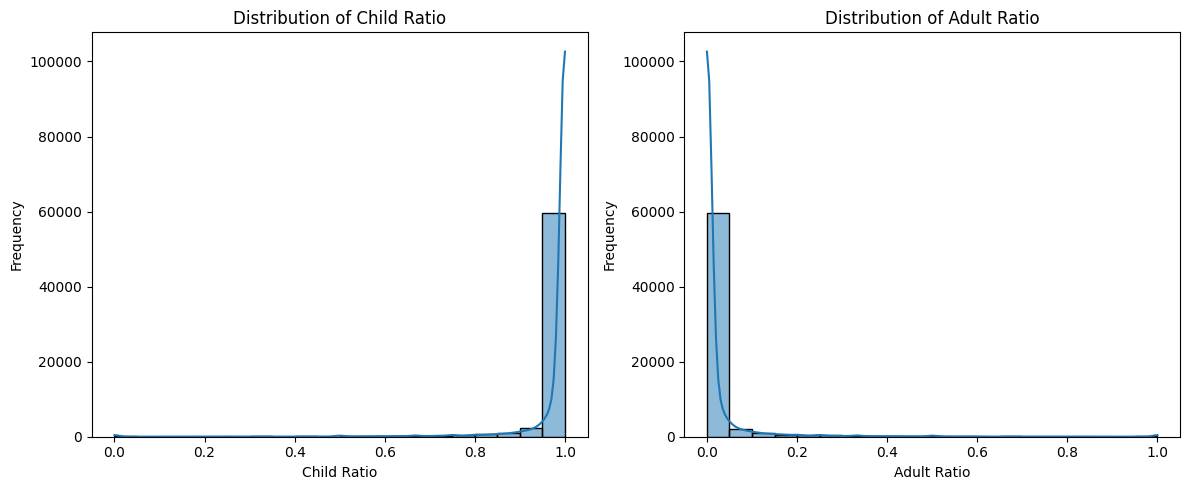

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
sns.histplot(daily_district['child_ratio'], bins=20, kde=True)
plt.title('Distribution of Child Ratio')
plt.xlabel('Child Ratio')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
sns.histplot(daily_district['adult_ratio'], bins=20, kde=True)
plt.title('Distribution of Adult Ratio')
plt.xlabel('Adult Ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Descriptive Statistics for Ratios

In [ ]:
print('Descriptive statistics for child_ratio:')
display(daily_district['child_ratio'].describe())

print('\nDescriptive statistics for adult_ratio:')
display(daily_district['adult_ratio'].describe())

Descriptive statistics for child_ratio:


,child_ratio
count,65315.000000
mean,0.977047
std,0.095000
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000



Descriptive statistics for adult_ratio:


,adult_ratio
count,65315.000000
mean,0.022953
std,0.095000
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000
